====================== Image Augmentation ======================

### Why Image Augmentation?

Large datasets are key to deep learning success, but collecting more data is expensive. **Image augmentation** generates modified training images on-the-fly, effectively expanding the dataset and improving generalization.

- Augmented images are **random transformations** of the originals — the model never sees the exact same image twice.
- Augmentation acts as a **regularizer**, reducing overfitting.
- At **test time**, no augmentation is applied (or predictions are averaged over multiple augmented copies).
- Use augmented images **only during training**.
- With augmentation, the model learns features **invariant** to the transformations (e.g., object position, lighting).

### Common Augmentation Techniques

| Technique | Description | PyTorch Transform |
|---|---|---|
| **Horizontal Flip** | Mirror image left-right (50% probability) | `RandomHorizontalFlip()` |
| **Vertical Flip** | Mirror image top-bottom | `RandomVerticalFlip()` |
| **Random Crop** | Crop a random region, resize back | `RandomResizedCrop(size, scale=(0.1, 1), ratio=(0.5, 2))` |
| **Color Jitter** | Randomly change brightness, contrast, saturation, hue | `ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)` |
| **Combine All** | Chain multiple transforms | `Compose([...])` |

### Key Takeaways

- Image augmentation is a **cheap** way to enlarge training data and reduce overfitting.
- The choice of augmentations should reflect **realistic variations** the model might encounter.
- Horizontal flipping and random cropping are almost universally beneficial; color jitter helps when lighting varies.
- Augmentation is a form of **implicit regularization** complementary to dropout and weight decay.

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

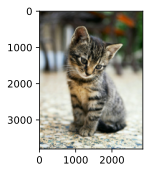

In [12]:
d2l.set_figsize()
img = d2l.Image.open('./Images/cat1.jpg')
d2l.plt.imshow(img);

In [15]:
# Most image augmentation methods have a certain degree of randomness. To make it easier for us to observe the effect of 
# image augmentation, next we define an auxiliary function apply. This function runs the image augmentation method aug 
# multiple times on the input image img and shows all the results.


def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

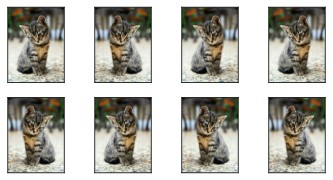

In [14]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

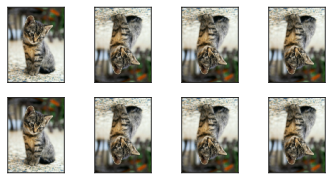

In [16]:
apply(img, torchvision.transforms.RandomVerticalFlip())

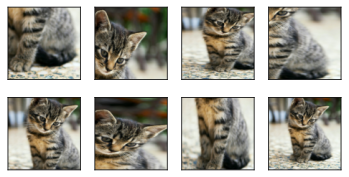

In [ ]:
# In the code below, we randomly crop an area with an area of 10% - 100% of the original area each time, and the ratio of width 
# to height of this area is randomly selected from 0.5 - 2. Then, the width and height of the region are both scaled to 200 
# pixels. Unless otherwise specified, the random number between a and b in this section refers to a continuous value obtained 
# by random and uniform sampling from the interval [a, b].


shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

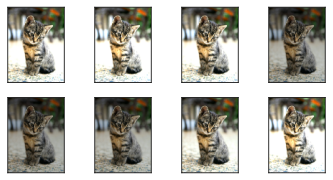

In [18]:

apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))

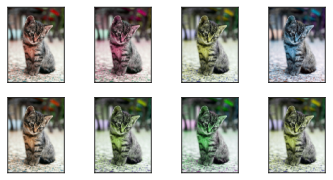

In [19]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

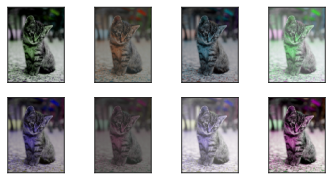

In [20]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

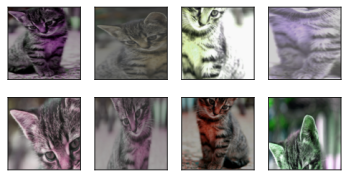

In [21]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

100.0%


Extracting ../data/cifar-10-python.tar.gz to ../data


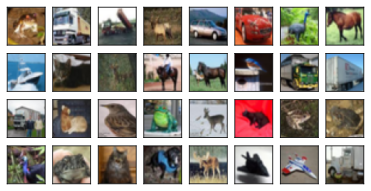

In [22]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [23]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

In [24]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

In [ ]:
#@save
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """Train for a minibatch with multiple GPUs (defined in Chapter 13)."""
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """Train a model with multiple GPUs (defined in Chapter 13)."""
    if not devices:
        devices = [torch.device('cpu')]
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    if devices[0].type == 'cuda':
        net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    else:
        net = net.to(devices[0])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [ ]:
devices = d2l.try_all_gpus()
if not devices:
    devices = [torch.device('cpu')]
batch_size, net = 256, d2l.resnet18(10, 3)
net.apply(d2l.init_cnn)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    net(next(iter(train_iter))[0])
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

In [ ]:
train_with_data_aug(train_augs, test_augs, net)

============================ Fine-Tuning ============================

### The Problem: Limited Data for New Tasks

Training a deep CNN from scratch requires millions of labeled images. Most real-world tasks have far fewer. **Transfer learning** via **fine-tuning** solves this by reusing a model pretrained on a large dataset (e.g., ImageNet).

### How Fine-Tuning Works

!["Fine tunning"](./Images/14/FineTunning.png)

#### Step-by-Step

1. **Pretrain** a model on a large source dataset (or download pretrained weights).
2. **Create target model**: Copy all layers except the output layer; initialize a new output layer for the target task.
3. **Train on target dataset**:
   - The new output layer is trained **from scratch** (larger learning rate).
   - All other layers are **fine-tuned** (smaller learning rate).

### Why It Works

| Layer Level | What It Learns | Transferability |
|---|---|---|
| **Early layers** | Edges, textures, colors | Highly transferable across tasks |
| **Middle layers** | Object parts, patterns | Moderately transferable |
| **Late layers** | Task-specific features | Less transferable — need retraining |

- Features learned from large datasets are **generic** enough to be useful for many tasks.
- Fine-tuning is much faster than training from scratch and works well even with small target datasets.

### Key Takeaways

- **Fine-tuning** transfers knowledge from source to target, requiring much less data and compute.
- Use a **smaller learning rate** for pretrained layers to preserve learned features; a **larger rate** for the new output layer.
- The more similar the source and target domains, the better the transfer.
- Fine-tuning is the **default strategy** in modern computer vision for tasks with limited data.

In [1]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [2]:
#@save
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

In [3]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

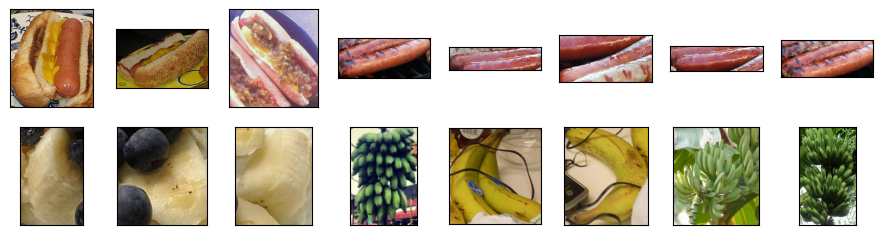

In [5]:
# The first 8 positive examples and the last 8 negative images are shown below. 
# As you can see, the images vary in size and aspect ratio.

hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

In [7]:
# During training, we first crop a random area of random size and random aspect ratio from the image, and then scale this area
# to a 224*224 input image. During testing, we scale both the height and width of an image to 256 pixels, and then crop a central
# 224*224 area as input. 
# In addition, for the three RGB (red, green, and blue) color channels we standardize their values channel by channel. 
# Concretely, the mean value of a channel is subtracted from each value of that channel and then the result is divided by 
# the standard deviation of that channel.



# Specify the means and standard deviations of the three RGB channels to
# standardize each channel
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

In [ ]:
# we specify pretrained=True to automatically download the pretrained model parameters. 
pretrained_net = torchvision.models.resnet18(pretrained=True)

/workspaces/pytorch-d2l/.venv310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/workspaces/pytorch-d2l/.venv310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/codespace/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


In [14]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

In [15]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

In [17]:
# If `param_group=True`, the model parameters in the output layer will be
# updated using a learning rate ten times greater
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    if not devices:
        devices = [torch.device('cpu')]
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

In [18]:
train_fine_tuning(finetune_net, 5e-5)

: 

In [ ]:
# For comparison, we define an identical model, but initialize all of its model parameters to random values. 
# Since the entire model needs to be trained from scratch, we can use a larger learning rate.

scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

============================= Object Detection and Bounding Boxes =============================

### From Classification to Detection

- **Image classification**: What is in the image? → one label
- **Object detection**: What objects are where? → multiple labels + **bounding boxes**

Object detection is fundamental to many applications: autonomous driving, surveillance, medical imaging, robotics.

### Bounding Boxes

A bounding box is an axis-aligned rectangle specified by:

$$\text{bbox} = (x_{\min}, y_{\min}, x_{\max}, y_{\max})$$

or equivalently by center + size:

$$\text{bbox} = (x_{\text{center}}, y_{\text{center}}, \text{width}, \text{height})$$

#### Conversion Between Formats

```python
def box_corner_to_center(boxes):
    """From (x_min, y_min, x_max, y_max) to (cx, cy, w, h)."""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    return torch.stack((cx, cy, w, h), axis=-1)

def box_center_to_corner(boxes):
    """From (cx, cy, w, h) to (x_min, y_min, x_max, y_max)."""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    return torch.stack((x1, y1, x2, y2), axis=-1)
```

### Ground Truth Annotations

- Each object in a training image is annotated with:
  - A **class label** (e.g., "dog", "cat", "car")
  - A **bounding box** around the object
- Datasets like **Pascal VOC**, **COCO**, and **ImageNet Detection** provide these annotations.

### Key Takeaways

- Object detection extends classification by **localizing** objects with bounding boxes.
- Bounding boxes can be represented in corner format $(x_{\min}, y_{\min}, x_{\max}, y_{\max})$ or center format $(c_x, c_y, w, h)$.
- Understanding bounding box representation is foundational to all detection algorithms (SSD, YOLO, Faster R-CNN, etc.).

================================= Anchor Boxes =================================

### Why Anchor Boxes?

Object detection requires predicting bounding boxes. Instead of predicting boxes from scratch, most detectors generate a large set of **anchor boxes** (prior boxes) and then:
1. **Classify** each anchor as containing an object or background.
2. **Refine** the anchor's position to better fit the object (offset regression).

### Generating Anchor Boxes

Anchors are centered at each pixel and generated with multiple **scales** $s$ and **aspect ratios** $r$:

$$\text{width} = s \cdot \sqrt{r}, \quad \text{height} = s / \sqrt{r}$$

For $n$ scales and $m$ ratios, we generate $n + m - 1$ anchors per pixel (not $n \times m$, to avoid redundancy):
- All scales with the first ratio: $(s_1, r_1), (s_2, r_1), \ldots, (s_n, r_1)$
- All ratios with the first scale: $(s_1, r_2), (s_1, r_3), \ldots, (s_1, r_m)$

For an $h \times w$ image: total anchors = $h \times w \times (n + m - 1)$.

### Intersection over Union (IoU)

IoU (Jaccard index) measures how well two boxes overlap:

$$J(\mathcal{A}, \mathcal{B}) = \frac{|\mathcal{A} \cap \mathcal{B}|}{|\mathcal{A} \cup \mathcal{B}|}$$

- $\text{IoU} = 0$: no overlap
- $\text{IoU} = 1$: perfect overlap
- Typically, an anchor is considered a **positive match** if IoU ≥ 0.5 with a ground-truth box.

### Assigning Ground-Truth to Anchors

The assignment ensures:
1. Each **ground-truth box** is assigned to at least one anchor (the one with highest IoU).
2. Remaining anchors are assigned to the ground-truth box with IoU ≥ threshold (e.g., 0.5), or labeled as **background**.

### Offset Prediction

Rather than predicting absolute box coordinates, the model predicts **offsets** from the anchor:

$$\hat{x} = (x - x_a) / w_a, \quad \hat{y} = (y - y_a) / h_a$$
$$\hat{w} = \log(w / w_a), \quad \hat{h} = \log(h / h_a)$$

where $(x_a, y_a, w_a, h_a)$ is the anchor and $(x, y, w, h)$ is the target.

### Non-Maximum Suppression (NMS)

Multiple anchors may predict overlapping boxes for the same object. **NMS** removes redundant predictions:

1. Sort predictions by confidence score.
2. Keep the top prediction; remove all predictions with IoU > threshold (e.g., 0.5) with it.
3. Repeat for remaining predictions.

### Key Takeaways

- **Anchor boxes** are predefined reference boxes that simplify detection by converting it into classification + regression.
- **IoU** is the standard metric for measuring bounding box overlap.
- **Offset regression** is more stable than directly predicting coordinates.
- **NMS** is essential post-processing to eliminate duplicate detections.

================================ Multiscale Object Detection ================================

### The Problem: Objects at Different Scales

Real images contain objects of vastly different sizes. A single set of anchor boxes at one resolution cannot efficiently detect both small and large objects.

### Solution: Feature Pyramid / Multiscale Detection

Generate anchor boxes at **multiple feature map scales**:

| Feature Map Scale | Detects | Anchor Behavior |
|---|---|---|
| **Fine-grained** (early layers, large spatial) | Small objects | Many small anchors, dense coverage |
| **Coarse** (deep layers, small spatial) | Large objects | Fewer large anchors, wide coverage |

At each scale:
- The feature map has spatial size $h \times w$.
- Each position generates anchors with various sizes and aspect ratios.
- Predictions (class + offset) are made per anchor.

### How It Works

For an input image and a CNN backbone:

```
Input Image (e.g., 256×256)
    ↓ CNN layers
Feature Map 1: 32×32  →  anchors for small objects
    ↓ more layers
Feature Map 2: 16×16  →  anchors for medium objects
    ↓ more layers
Feature Map 3: 8×8    →  anchors for large objects
    ↓ more layers
Feature Map 4: 4×4    →  anchors for very large objects
```

- At each scale, anchor **sizes are relative** to the feature map — a $0.15 \times 0.15$ anchor on a $4 \times 4$ map covers a large image region.
- This is the foundation of architectures like **SSD** and **Feature Pyramid Networks (FPN)**.

### Key Takeaways

- **Multiscale detection** is essential for handling objects of varying sizes in one image.
- Lower-level (higher-resolution) feature maps detect **small objects**; higher-level (lower-resolution) maps detect **large objects**.
- Generating anchors at multiple scales provides **comprehensive spatial coverage** without excessive computation.
- This principle is used in SSD, RetinaNet, FPN, and YOLO variants.

================================ The Object Detection Dataset ================================

### Overview

This section introduces a small **banana detection dataset** used as a pedagogical example, along with data loading utilities for object detection.

### Dataset Format

Each training example consists of:
- An **image** (e.g., $256 \times 256$)
- **Labels**: a tensor of shape $(m, 5)$ where $m$ is the number of objects, and each row is:
  - `[class_label, x_min, y_min, x_max, y_max]`
  - Bounding box coordinates are **normalized** to $[0, 1]$ (relative to image size)

### Data Loading for Detection

Unlike classification (one label per image), detection requires:
- Variable numbers of objects per image → labels are **padded** to a fixed maximum.
- Bounding boxes must be **transformed** alongside images during augmentation (e.g., if an image is flipped, boxes flip too).

```python
# Custom dataset class for detection
class BananasDataset(torch.utils.data.Dataset):
    def __init__(self, is_train):
        # Read images and labels from CSV
        # Labels: [class, xmin, ymin, xmax, ymax] normalized
        ...
    def __getitem__(self, idx):
        return image, label  # label shape: (max_objects, 5)
```

### Key Takeaways

- Object detection datasets pair images with **variable-length** bounding box annotations.
- Normalized coordinates ($[0, 1]$) make labels resolution-independent.
- Data loaders must handle **padding** for batching and **coordinate transforms** for augmentation.
- The banana dataset is a simple, fast-to-train example for learning detection pipelines.

================================= Single Shot Multibox Detection =================================

### Overview

**SSD** (Single Shot Multibox Detection) is an end-to-end object detection model that predicts bounding boxes and class labels in a **single forward pass** — no separate region proposal stage.

### Architecture

```
Input Image (256×256)
    ↓
Base Network (truncated VGG/ResNet) → Feature Map
    ↓
Multiscale Feature Blocks (progressively smaller)
    ↓ at each scale:
    ├── Anchor Generation (multiple sizes & ratios per pixel)
    ├── Class Prediction (conv → num_anchors × (num_classes + 1))
    └── Bbox Offset Prediction (conv → num_anchors × 4)
    ↓
Concatenate all predictions across scales
    ↓
NMS → Final Detections
```

### Key Components

#### 1. Base Network
- Extracts features from the input image.
- Typically a pretrained backbone (VGG, ResNet) truncated before classification layers.
- Outputs a feature map (e.g., $32 \times 32$).

#### 2. Multiscale Feature Blocks
- Each block **halves** spatial resolution (via stride-2 conv or pooling).
- Produces a hierarchy of feature maps for detecting objects at different scales.
- Example: $32 \times 32 \to 16 \times 16 \to 8 \times 8 \to 4 \times 4 \to 1 \times 1$.

#### 3. Prediction Layers (per scale)

| Layer | Output Shape | Purpose |
|---|---|---|
| **Class prediction** | $h \times w \times a(q+1)$ | Predict class for each of $a$ anchors ($q$ classes + background) |
| **Bbox prediction** | $h \times w \times 4a$ | Predict 4 offsets for each anchor |

where $a = n_{\text{sizes}} + n_{\text{ratios}} - 1$ anchors per pixel.

#### 4. Training

**Loss function** combines:

$$\mathcal{L} = \mathcal{L}_{\text{cls}}(\text{class predictions}, \text{labels}) + \lambda \cdot \mathcal{L}_{\text{bbox}}(\text{offset predictions}, \text{offsets})$$

- $\mathcal{L}_{\text{cls}}$: Cross-entropy loss for classification
- $\mathcal{L}_{\text{bbox}}$: $L_1$ loss for bounding box offsets (only for non-background anchors)

#### 5. Prediction / Inference

1. Forward pass → class scores + offsets for all anchors at all scales.
2. Apply offsets to anchor boxes → predicted bounding boxes.
3. Filter out low-confidence predictions.
4. Apply **NMS** per class to remove duplicates.

### Key Takeaways

- SSD is a **single-stage** detector — fast and end-to-end trainable.
- **Multiscale** feature maps enable detection of objects at various sizes.
- Each spatial position at each scale predicts classes and box offsets for multiple anchors.
- SSD trades some accuracy for significant **speed advantages** over two-stage detectors like Faster R-CNN.

=================================== Region-based CNNs (R-CNNs) ===================================

### Overview

Region-based CNNs are **two-stage** detectors: first propose candidate regions, then classify each region. This family includes **R-CNN**, **Fast R-CNN**, and **Faster R-CNN**.

### Evolution of R-CNN Family

#### 1. R-CNN (Girshick et al., 2014)

```
Input Image
    ↓
Selective Search → ~2000 Region Proposals
    ↓ for each proposal:
    Warp to fixed size → CNN (pretrained) → Feature Vector
    ↓
    SVM Classifier + Bounding Box Regressor
```

**Problems**: Very slow (CNN runs ~2000 times per image), multi-stage training.

#### 2. Fast R-CNN (Girshick, 2015)

```
Input Image → CNN → Full Feature Map (computed ONCE)
    ↓
Selective Search → Region Proposals
    ↓
RoI Pooling (extract fixed-size features per proposal from shared feature map)
    ↓
FC layers → Class Prediction + Bbox Regression
```

**Key innovation**: **RoI (Region of Interest) Pooling** — extracts fixed-size feature maps from varying-size proposals on the shared feature map.
- CNN runs only **once** per image (big speedup).
- End-to-end training (except selective search).

#### 3. Faster R-CNN (Ren et al., 2015)

```
Input Image → CNN → Shared Feature Map
    ↓
Region Proposal Network (RPN):
    ├── Anchor generation at each position
    ├── Binary classification (object vs. background)
    └── Bbox regression (refine anchors)
    ↓
RoI Pooling → FC → Class + Bbox
```

**Key innovation**: **Region Proposal Network (RPN)** — replaces selective search with a learned proposal generator.

| Component | R-CNN | Fast R-CNN | Faster R-CNN |
|---|---|---|---|
| **Proposals** | Selective Search | Selective Search | RPN (learned) |
| **CNN passes** | ~2000/image | 1/image | 1/image |
| **Training** | Multi-stage | End-to-end (almost) | Fully end-to-end |
| **Speed** | Very slow | Fast | Faster |

### RoI Pooling

Converts variable-size regions into fixed-size feature maps:

1. Divide the RoI into a grid of $H \times W$ bins.
2. **Max-pool** within each bin.
3. Output: $H \times W$ feature map regardless of input RoI size.

### Key Takeaways

- **Two-stage** detectors (propose → classify) achieve high accuracy, especially for complex scenes.
- **RoI Pooling** enables sharing computation across all proposals.
- **Faster R-CNN** with RPN is the most influential two-stage detector and foundation for many modern detectors (Mask R-CNN, Cascade R-CNN).
- Two-stage detectors are generally more accurate but slower than single-stage detectors (SSD, YOLO).

============================== Semantic Segmentation and the Dataset ==============================

### From Detection to Segmentation

| Task | Granularity | Output |
|---|---|---|
| **Image Classification** | Image-level | One label per image |
| **Object Detection** | Box-level | Bounding boxes + labels |
| **Semantic Segmentation** | Pixel-level | A class label for **every pixel** |
| **Instance Segmentation** | Pixel-level + instance | Class + instance ID per pixel |

### Semantic Segmentation

- Assign a **class label** to each pixel (e.g., road, car, person, sky).
- Unlike detection, there are **no bounding boxes** — the output is a dense label map the same size as the input.
- Applications: autonomous driving, medical imaging, satellite analysis.

### The Pascal VOC2012 Dataset

A standard benchmark for semantic segmentation:

- **Images**: Natural scenes with 20 foreground object classes + 1 background class.
- **Labels**: Color-coded segmentation maps where each pixel color maps to a class.
- **Colormap**: Each of the 21 classes has a unique RGB color.

```python
# VOC colormap: class index → RGB
VOC_COLORMAP = [[0, 0, 0],      # background
                [128, 0, 0],    # aeroplane
                [0, 128, 0],    # bicycle
                ...
                [0, 64, 128]]   # train
```

### Data Preprocessing for Segmentation

Key differences from classification:

1. **Random cropping**: Both image and label must be cropped at the **same location**.
2. **No resizing to different aspect ratios** — this would distort the label map.
3. **Normalization**: Applied to images only (not labels).
4. **Labels are integer tensors** (class indices), not one-hot encoded.

```python
def voc_rand_crop(feature, label, height, width):
    """Randomly crop both feature (image) and label (segmentation map)."""
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label
```

### Key Takeaways

- Semantic segmentation provides **pixel-level understanding** — the finest granularity of visual recognition.
- The label for each pixel is a class index; the output is a **dense prediction map**.
- Data augmentation (especially cropping) must be applied **identically** to both image and label.
- Pascal VOC2012 is the standard training/evaluation dataset with 21 classes.

================================ Transposed Convolution ================================

### The Problem: Upsampling

CNNs progressively **downsample** spatial resolution (via convolution strides and pooling). For dense prediction tasks like semantic segmentation, we need to **upsample** back to the original resolution.

**Transposed convolution** (sometimes called "deconvolution") is a learnable upsampling operation.

### How Transposed Convolution Works

A standard convolution maps a larger input to a smaller output. A transposed convolution does the **reverse**: it maps a smaller input to a larger output.

#### Basic Operation (no padding, no stride)

For input size $n$, kernel size $k$:
- **Standard conv**: output size = $n - k + 1$ (shrinks)
- **Transposed conv**: output size = $n + k - 1$ (grows)

The transposed convolution:
1. Places each input element as the **center** of a scaled copy of the kernel.
2. **Sums** overlapping contributions.

$$\text{Output}[i+a, j+b] \mathrel{+}= \text{Input}[i, j] \times \text{Kernel}[a, b]$$

### With Padding and Stride

| Parameter | Effect on Transposed Conv |
|---|---|
| **Padding** $p$ | Removes $p$ rows/cols from output border → output size **decreases** |
| **Stride** $s$ | Inserts $s-1$ zeros between input elements → output size **increases** |

Output size formula:

$$o = s \cdot (n - 1) + k - 2p$$

Common configuration to **exactly double** resolution: $k=4, s=2, p=1$ → $o = 2n$.

### Implementation

```python
# Transposed conv that doubles spatial resolution
tconv = nn.ConvTranspose2d(in_channels, out_channels,
                           kernel_size=4, stride=2, padding=1)
# Input: (batch, C, H, W) → Output: (batch, C', 2H, 2W)
```

### Connection to Standard Convolution

The transposed convolution is the **transpose** of the matrix form of standard convolution. If standard conv is represented as matrix $\mathbf{W}$:
- Forward (conv): $\mathbf{y} = \mathbf{W} \mathbf{x}$
- Transposed conv: $\mathbf{x}' = \mathbf{W}^\top \mathbf{y}$

**Note**: Transposed convolution is NOT the inverse of convolution — it does not recover the original input.

### Key Takeaways

- Transposed convolution is a **learnable upsampling** operation essential for dense prediction.
- It increases spatial resolution by the stride factor.
- Kernel weights are **learned**, unlike bilinear/nearest-neighbor upsampling.
- The $k=4, s=2, p=1$ configuration is standard for $2\times$ upsampling.
- It's the building block for decoder networks in U-Net, FCN, and generative models (GANs).

============================= Fully Convolutional Networks (FCN) =============================

### Overview

**Fully Convolutional Networks (FCN)** (Long et al., 2015) pioneered using CNNs for **pixel-level** semantic segmentation by replacing fully connected layers with convolutional layers and adding transposed convolutions for upsampling.

### Architecture

```
Input Image (H × W × 3)
    ↓
Pretrained CNN Backbone (e.g., ResNet-18)
    → Feature Map (H/32 × W/32 × 512)   [encoder/downsampling path]
    ↓
1×1 Convolution (512 → num_classes)
    → Score Map (H/32 × W/32 × num_classes)
    ↓
Transposed Convolution (×32 upsampling)
    → Dense Prediction (H × W × num_classes)
    ↓
argmax per pixel → Segmentation Map
```

### Key Ideas

#### 1. Replace FC Layers with Convolutions
- Standard classification CNNs end with FC layers (fixed input size).
- FCN replaces them with $1 \times 1$ convolutions → can handle **any input size**.
- The $1 \times 1$ conv projects channel features to `num_classes` at each spatial position.

#### 2. Transposed Convolution for Upsampling
- The backbone reduces resolution by $32\times$ (5 pooling layers with stride 2).
- A transposed convolution **upsamples** back to original resolution.
- Initialized with **bilinear interpolation** weights for stable training.

```python
def bilinear_kernel(in_channels, out_channels, kernel_size):
    """Initialize transposed conv weights for bilinear upsampling."""
    factor = (kernel_size + 1) // 2
    center = (kernel_size - 1) / 2
    og = torch.arange(kernel_size).reshape(-1, 1).float()
    filt = (1 - torch.abs(og - center) / factor) * \
           (1 - torch.abs(og.T - center) / factor)
    weight = torch.zeros(in_channels, out_channels, kernel_size, kernel_size)
    for i in range(in_channels):
        weight[i, i % out_channels] = filt
    return weight
```

#### 3. Transfer Learning
- Use a pretrained backbone (ResNet) as the encoder — features are already good.
- Only the $1 \times 1$ conv and transposed conv layers need training from scratch.

### Training

- **Loss**: Cross-entropy loss per pixel.
- **Input**: Random crops of images + label maps (same crop for both).
- **Output**: Per-pixel class predictions.

### Key Takeaways

- FCN was the **first** end-to-end trainable architecture for semantic segmentation.
- Key insight: replace FC layers with $1 \times 1$ conv → spatial output instead of vector output.
- **Bilinear initialization** of transposed convolution weights stabilizes training.
- Modern successors: U-Net (skip connections), DeepLab (atrous/dilated convolutions), PSPNet (pyramid pooling).

=================================== Neural Style Transfer ===================================

### Overview

**Neural Style Transfer** (Gatys et al., 2016) combines the **content** of one image with the **style** of another to produce a new, stylized image. It leverages CNN feature representations extracted from a pretrained network (VGG-19).

### How It Works

```
Content Image (photograph)  +  Style Image (painting)
                    ↓
    Optimization: find a Synthesized Image that
    minimizes content loss + style loss + TV loss
                    ↓
    Stylized Output Image
```

The synthesized image is the **variable being optimized** (not the network weights).

### Loss Functions

#### 1. Content Loss

Measures how similar the synthesis is to the content image **in feature space**:

$$\mathcal{L}_{\text{content}} = \frac{1}{2} \| \mathbf{F}^{(l)}_{\text{synth}} - \mathbf{F}^{(l)}_{\text{content}} \|_F^2$$

- Extracted from a **single deep layer** (e.g., `conv4_2` of VGG-19).
- Deep features capture **high-level structure** (objects, layout) but not exact pixels.

#### 2. Style Loss

Measures how similar the **texture/style** is using **Gram matrices**:

$$\mathbf{G}^{(l)} = \mathbf{F}^{(l)} {\mathbf{F}^{(l)}}^\top$$

The Gram matrix captures **correlations between feature channels** — encoding texture, color patterns, and brushstroke-like information.

$$\mathcal{L}_{\text{style}} = \sum_l w_l \| \mathbf{G}^{(l)}_{\text{synth}} - \mathbf{G}^{(l)}_{\text{style}} \|_F^2$$

- Computed across **multiple layers** (e.g., `conv1_1` through `conv5_1`) to capture style at different scales.

#### 3. Total Variation (TV) Loss

Encourages spatial smoothness, reducing noise:

$$\mathcal{L}_{\text{TV}} = \sum_{i,j} \left| x_{i+1,j} - x_{i,j} \right| + \left| x_{i,j+1} - x_{i,j} \right|$$

#### Combined Loss

$$\mathcal{L} = \alpha \cdot \mathcal{L}_{\text{content}} + \beta \cdot \mathcal{L}_{\text{style}} + \gamma \cdot \mathcal{L}_{\text{TV}}$$

- $\alpha, \beta, \gamma$ control the balance between content fidelity, style strength, and smoothness.

### Optimization

- Initialize synthesized image as the content image (or random noise).
- **Freeze** the VGG-19 network (pretrained, not training it).
- Use gradient descent (L-BFGS or Adam) to update **pixel values** of the synthesized image.

### Key Takeaways

- Neural style transfer is an **optimization over pixels**, not over network weights.
- **Content loss** (deep features) preserves structure; **style loss** (Gram matrices) transfers texture/patterns.
- VGG-19 features at different depths capture different abstraction levels of content and style.
- The Gram matrix is a powerful representation of **texture** independent of spatial arrangement.
- $\alpha/\beta$ ratio controls the content–style tradeoff.

============================= Image Classification (CIFAR-10) on Kaggle =============================

### Overview

This section walks through a complete Kaggle competition pipeline for **CIFAR-10 image classification** (10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). It covers data organization, augmentation, model selection, and submission.

### Dataset Details

| Property | Value |
|---|---|
| **Training images** | 50,000 (5,000 per class) |
| **Test images** | 300,000 (Kaggle test set) |
| **Image size** | $32 \times 32 \times 3$ |
| **Classes** | 10 |

### Pipeline

#### 1. Data Organization

```
data/cifar-10/
├── train/           # 50,000 images: id.png
├── test/            # 300,000 images: id.png
├── trainLabels.csv  # id → label mapping
└── sampleSubmission.csv
    ↓ reorganize into:
train_valid_test/
├── train/          # Per-class folders (for DataLoader)
│   ├── airplane/
│   ├── automobile/
│   └── ...
├── valid/          # Hold-out validation set
├── train_valid/    # Full training set (for final submission)
└── test/
```

#### 2. Image Augmentation

```python
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0), ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])
```

- Training: random crop + horizontal flip + normalization.
- Test: only normalization (no augmentation).

#### 3. Model

- Use **ResNet-18** (or deeper) — modify first conv for $32 \times 32$ input (smaller kernel, no stride).
- Can fine-tune from pretrained ImageNet weights or train from scratch.

#### 4. Training Strategy

- **K-fold cross-validation** to tune hyperparameters.
- After finding best hyperparameters, retrain on **full training set** (train + validation).
- Generate predictions on test set → submit to Kaggle.

#### 5. Submission

```python
# Predict on test set, write CSV
# Columns: id, predicted_label
```

### Key Takeaways

- A complete competition pipeline: data preprocessing → augmentation → model → training → submission.
- **Data augmentation** is critical for small-image datasets like CIFAR-10.
- **K-fold cross-validation** helps select robust hyperparameters.
- Retrain on the **full dataset** for the final submission to maximize performance.
- CIFAR-10 is a stepping stone to harder benchmarks (CIFAR-100, ImageNet).

=================== Dog Breed Identification (ImageNet Dogs) on Kaggle ===================

### Overview

This Kaggle competition requires classifying images into **120 dog breeds** — a fine-grained classification task where differences between classes are subtle (e.g., distinguishing a Siberian Husky from an Alaskan Malamute).

### Why This Is Harder Than CIFAR-10

| Challenge | CIFAR-10 | Dog Breeds |
|---|---|---|
| **Classes** | 10 (very different) | 120 (very similar) |
| **Image size** | $32 \times 32$ | Variable (high-res) |
| **Difficulty** | Low | High (fine-grained) |
| **Data per class** | 5,000 | ~100 |

### Pipeline

#### 1. Data Preprocessing

- Images are **variable size** → resize to $224 \times 224$ (standard ImageNet input).
- Use **ImageNet normalization** (mean and std of ImageNet dataset).

#### 2. Heavy Data Augmentation

Fine-grained classification with limited data demands aggressive augmentation:

```python
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(3/4, 4/3)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])
```

#### 3. Transfer Learning (Essential!)

- Use a **pretrained ResNet** (or other ImageNet model) — these models have already seen dogs.
- Replace the final FC layer: 1000 classes → 120 dog breeds.
- Fine-tune with a **small learning rate** on pretrained layers, larger on the new head.

```python
pretrained_net = torchvision.models.resnet34(pretrained=True)
# Freeze most layers, replace output
pretrained_net.fc = nn.Linear(pretrained_net.fc.in_features, 120)
```

#### 4. Training

- Use **cross-entropy loss**.
- Fine-tune for ~20–80 epochs with cosine/step learning rate schedule.
- Monitor validation accuracy to avoid overfitting.

#### 5. Submission

- Predict **probabilities** for all 120 classes (not just top-1).
- Kaggle evaluates with **log-loss** (cross-entropy), so calibrated probabilities matter.

### Key Takeaways

- **Fine-grained classification** is much harder than coarse classification — classes are visually similar.
- **Transfer learning** is essential when per-class data is scarce (~100 images per breed).
- **Aggressive augmentation** (random crop, color jitter, flips) helps prevent overfitting on small data.
- Pretrained ImageNet features are highly relevant since the source dataset already contains dog images.
- **Log-loss** evaluation means the model must output well-calibrated probabilities, not just correct labels.